In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


In [191]:
start = '1989-01-01'
end = '2023-12-31'

stock = 'MSFT'
data = yf.download(stock,start,end)

[*********************100%%**********************]  1 of 1 completed


In [192]:
data.reset_index(inplace=True)

In [193]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1989-01-03,0.371528,0.373264,0.366319,0.372396,0.230031,51825600
1,1989-01-04,0.371528,0.381076,0.371528,0.376736,0.232712,53899200
2,1989-01-05,0.380208,0.380208,0.369792,0.370660,0.228959,47246400
3,1989-01-06,0.371528,0.373264,0.368056,0.368056,0.227350,59054400
4,1989-01-09,0.368056,0.369792,0.361979,0.364583,0.225205,46008000
...,...,...,...,...,...,...,...
8812,2023-12-22,373.679993,375.179993,372.709991,374.579987,373.215424,17091100
8813,2023-12-26,375.000000,376.940002,373.500000,374.660004,373.295135,12673100
8814,2023-12-27,373.690002,375.059998,372.809998,374.070007,372.707275,14905400
8815,2023-12-28,375.369995,376.459991,374.160004,375.279999,373.912842,14327000


In [194]:
mva_days=data.Close.rolling(200).mean()
win_size=2
arr1=np.array(mva_days)
arr2=np.array(data.Close)

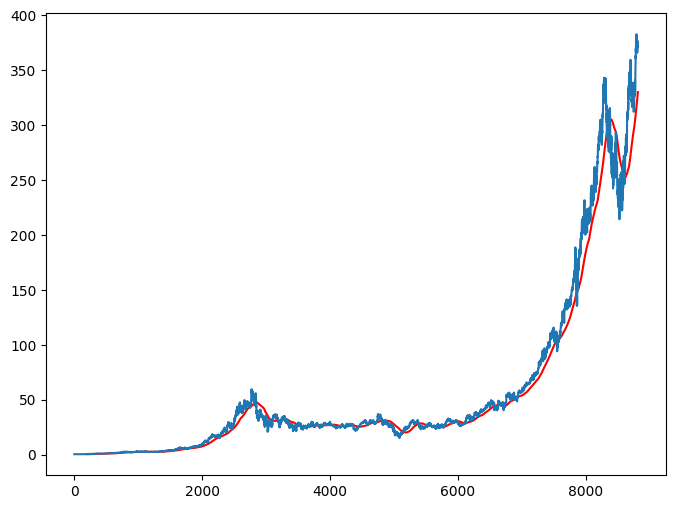

In [195]:
plt.figure(figsize=(8,6))
plt.plot(mva_days,'r')
plt.plot(data.Close)
plt.show()

In [196]:
'''# Checks if there is a local top detected at curr index
def rw_top(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    top = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] > v or data[k - i] > v:
            top = False
            break
    
    return top

# Checks if there is a local top detected at curr index
def rw_bottom(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    bottom = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] < v or data[k - i] < v:
            bottom = False
            break
    
    return bottom

def rw_extremes(data: np.array, order:int):
    # Rolling window local tops and bottoms
    tops = []
    bottoms = []
    for i in range(len(data)):
        if rw_top(data, i, order):
            # top[0] = confirmation index
            # top[1] = index of top
            # top[2] = price of top
            top = [i, i - order, data[i - order]]
            tops.append(top)
        
        if rw_bottom(data, i, order):
            # bottom[0] = confirmation index
            # bottom[1] = index of bottom
            # bottom[2] = price of bottom
            bottom = [i, i - order, data[i - order]]
            bottoms.append(bottom)
    
    return tops, bottoms


tops, bottoms=rw_extremes(arr2,1)

arr_tops=[]
arr_bottoms=[]
for i in range(len(tops)):
    arr_tops.append(tops[i][0])

for i in range(len(bottoms)):
    arr_bottoms.append(bottoms[i][0])
    
print(len(arr_tops),len(arr_bottoms))

print(arr_tops)
print(arr_bottoms)

ex=np.concatenate((arr_tops,arr_bottoms))

days_between = []
for i in range(len(tops)):

    days_between.append(abs(arr_bottoms[i]-arr_tops[i]))

        
print(days_between)
print(len(days_between))'''

'# Checks if there is a local top detected at curr index\ndef rw_top(data: np.array, curr_index: int, order: int) -> bool:\n    if curr_index < order * 2 + 1:\n        return False\n\n    top = True\n    k = curr_index - order\n    v = data[k]\n    for i in range(1, order + 1):\n        if data[k + i] > v or data[k - i] > v:\n            top = False\n            break\n    \n    return top\n\n# Checks if there is a local top detected at curr index\ndef rw_bottom(data: np.array, curr_index: int, order: int) -> bool:\n    if curr_index < order * 2 + 1:\n        return False\n\n    bottom = True\n    k = curr_index - order\n    v = data[k]\n    for i in range(1, order + 1):\n        if data[k + i] < v or data[k - i] < v:\n            bottom = False\n            break\n    \n    return bottom\n\ndef rw_extremes(data: np.array, order:int):\n    # Rolling window local tops and bottoms\n    tops = []\n    bottoms = []\n    for i in range(len(data)):\n        if rw_top(data, i, order):\n      

In [226]:
def directional_change(close: np.array, high: np.array, low: np.array, sigma: float):
    
    up_zig = True # Last extreme is a bottom. Next is a top. 
    tmp_max = high[0]
    tmp_min = low[0]
    tmp_max_i = 0
    tmp_min_i = 0

    tops = []
    bottoms = []

    for i in range(len(close)):
        if up_zig: # Last extreme is a bottom
            if high[i] > tmp_max:
                # New high, update 
                tmp_max = high[i]
                tmp_max_i = i
            elif close[i] < tmp_max - tmp_max * sigma: 
                # Price retraced by sigma %. Top confirmed, record it
                # top[0] = confirmation index
                # top[1] = index of top
                # top[2] = price of top
                top = [i, tmp_max_i, tmp_max]
                tops.append(top)

                # Setup for next bottom
                up_zig = False
                tmp_min = low[i]
                tmp_min_i = i
        else: # Last extreme is a top
            if low[i] < tmp_min:
                # New low, update 
                tmp_min = low[i]
                tmp_min_i = i
            elif close[i] > tmp_min + tmp_min * sigma: 
                # Price retraced by sigma %. Bottom confirmed, record it
                # bottom[0] = confirmation index
                # bottom[1] = index of bottom
                # bottom[2] = price of bottom
                bottom = [i, tmp_min_i, tmp_min]
                bottoms.append(bottom)

                # Setup for next top
                up_zig = True
                tmp_max = high[i]
                tmp_max_i = i

    return tops, bottoms

tops1,bottoms1=directional_change(arr1,data.High,data.Low,0.01)

arr_tops1=[]
arr_bottoms1=[]
for i in range(len(tops1)):
    arr_tops1.append(tops1[i][0])

for i in range(len(bottoms1)):
    arr_bottoms1.append(bottoms1[i][0])
    

print(len(arr_tops1),len(arr_bottoms1))

extremes=np.concatenate((arr_tops1,arr_bottoms1))

print(arr_tops1)
print(arr_bottoms1)

days_between1 = []
if tops1[0][0]>bottoms1[0][0]:
    days_between1.append(bottoms1[0][0])
    for i in range(len(tops1)):
        days_between1.append(abs(arr_bottoms1[i]-arr_tops1[i]))
        days_between1.append(abs(arr_bottoms1[i]-arr_tops1[i-1]))

else:
    days_between1.append(bottoms1[0][0])
    for i in range(len(bottoms1)):
        days_between1.append(abs(arr_tops1[i]-arr_bottoms1[i]))
        days_between1.append(abs(arr_tops1[i]-arr_bottoms1[i-1]))

days_between1.pop(2)        
print(days_between1)
print(len(days_between1))
print(np.mean(days_between1))
print(np.std(days_between1))

count=0
day=np.array(days_between1)
for i in range(len(day)):
    if day[i]<1:
        count+=1
print(count)


203 202
[199, 280, 361, 420, 427, 434, 443, 458, 478, 520, 636, 673, 759, 869, 873, 879, 930, 936, 949, 954, 1045, 1050, 1075, 1093, 1109, 1167, 1206, 1209, 1238, 1246, 1271, 1306, 1316, 1365, 1452, 1529, 1577, 1653, 1723, 1744, 1756, 1763, 1771, 1783, 1792, 1830, 1901, 1953, 2039, 2139, 2258, 2276, 2290, 2325, 2413, 2472, 2498, 2548, 2655, 2708, 2739, 2744, 2756, 2784, 2823, 2825, 2828, 2838, 2927, 3011, 3072, 3108, 3197, 3236, 3245, 3273, 3316, 3327, 3355, 3467, 3493, 3536, 3547, 3587, 3596, 3598, 3605, 3609, 3648, 3654, 3667, 3691, 3767, 3774, 3816, 3862, 3897, 3992, 4017, 4107, 4175, 4186, 4226, 4252, 4334, 4449, 4505, 4585, 4594, 4614, 4649, 4676, 4691, 4724, 4751, 4869, 4943, 4990, 5059, 5141, 5147, 5249, 5372, 5384, 5507, 5510, 5528, 5613, 5626, 5677, 5716, 5720, 5728, 5744, 5760, 5787, 5797, 5826, 5914, 5938, 5943, 5952, 6040, 6117, 6135, 6248, 6305, 6341, 6429, 6510, 6631, 6667, 6686, 6698, 6748, 6801, 6832, 6847, 6898, 6905, 6941, 6975, 7059, 7163, 7252, 7330, 7400, 7487, 752

In [198]:
data_train = pd.DataFrame(days_between1[0: int(len(days_between1)*0.80)])
data_test = pd.DataFrame(days_between1[int(len(days_between1)*0.80): len(days_between1)])

In [199]:
data_train.shape[0]

323

In [200]:
data_test.shape[0]


81

In [201]:
from sklearn.preprocessing import MinMaxScaler as mms
scaler = mms(feature_range=(0,1))


In [202]:
data_train_scale=scaler.fit_transform(data_train)


In [203]:
x=[]
y=[]

for i in range (win_size,data_train_scale.shape[0]):
    x.append(data_train_scale[i-win_size:i])
    y.append(data_train_scale[i,0])
    

In [204]:
x, y = np.array(x), np.array(y)
x.shape[0]

321

In [205]:
import tensorflow.keras as keras
from keras.layers import Dense, Dropout,LSTM
from keras.models import Sequential

In [206]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences =True,
               input_shape = ((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, return_sequences =True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, return_sequences =True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, return_sequences =False))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [207]:
model.compile(optimizer = 'adam' , loss = 'mean_squared_error')

In [208]:
hist = model.fit(x,y, epochs = 200, batch_size = 128 , verbose = 1)

Epoch 1/200
3/3 [==============================] - 6s 35ms/step - loss: 0.0151
Epoch 2/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0123
Epoch 3/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0109
Epoch 4/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0106
Epoch 5/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0112
Epoch 6/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0108
Epoch 7/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0106
Epoch 8/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0106
Epoch 9/200
3/3 [==============================] - 0s 35ms/step - loss: 0.0106
Epoch 10/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0106
Epoch 11/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0106
Epoch 12/200
3/3 [==============================] - 0s 36ms/step - loss: 0.0105
Epoch 13/200
3/3 [==============================]

In [209]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 2, 50)             10400     
                                                                 
 dropout_24 (Dropout)        (None, 2, 50)             0         
                                                                 
 lstm_25 (LSTM)              (None, 2, 60)             26640     
                                                                 
 dropout_25 (Dropout)        (None, 2, 60)             0         
                                                                 
 lstm_26 (LSTM)              (None, 2, 80)             45120     
                                                                 
 dropout_26 (Dropout)        (None, 2, 80)             0         
                                                                 
 lstm_27 (LSTM)              (None, 120)              

In [210]:
pst_days=data_train.tail(win_size)

In [211]:
data_test=pd.concat([pst_days,data_test],ignore_index=True)

In [212]:
data_test_scale =  scaler.fit_transform(data_test)

In [213]:
x=[]
y=[]

for i in range (win_size,data_test_scale.shape[0]):
    x.append(data_test_scale[i-win_size:i])
    y.append(data_test_scale[i,0])

x, y = np.array(x), np.array(y)

In [214]:
y_predict = model.predict(x)

3/3 [==============================] - 1s 6ms/step


In [215]:
scale=1/scaler.scale_
scale

array([107.])

In [216]:
y_predict=y_predict*scale

In [217]:
y=y*scale

In [218]:
print(data_test)
print('**')
for i in range (len(y_predict)):
    predict=np.ceil(y_predict).flatten()
print(y_predict)

      0
0    24
1    83
2     2
3   102
4     1
..  ...
78    6
79   81
80    4
81   84
82    2

[83 rows x 1 columns]
**
[[15.41211136]
 [22.46721862]
 [ 9.21266302]
 [23.43501501]
 [ 8.4005534 ]
 [22.75528803]
 [ 8.46577492]
 [22.08332112]
 [ 7.68078007]
 [21.39899902]
 [ 8.33576078]
 [22.6434599 ]
 [ 6.66438125]
 [17.16721849]
 [ 4.29633159]
 [ 8.30709702]
 [ 4.60369633]
 [10.18893457]
 [ 3.72422028]
 [ 4.29756807]
 [ 3.89226702]
 [ 5.62060616]
 [ 4.45948185]
 [ 5.52971282]
 [ 8.58719431]
 [ 6.90828471]
 [ 5.62060616]
 [ 4.29756807]
 [ 4.05660592]
 [ 6.77693604]
 [ 5.95624921]
 [14.24392135]
 [ 9.11119705]
 [22.5302494 ]
 [ 8.43239724]
 [22.81282124]
 [ 7.51600111]
 [21.04049113]
 [ 6.13880002]
 [ 3.63878186]
 [ 3.72422028]
 [ 4.45948185]
 [ 5.94276755]
 [11.11798406]
 [ 8.43574633]
 [21.04572244]
 [ 8.97297163]
 [23.67808658]
 [ 6.77627595]
 [19.21470317]
 [ 8.85967424]
 [22.0138983 ]
 [ 8.84192989]
 [23.46454853]
 [ 8.12534142]
 [16.96101479]
 [ 4.60369633]
 [10.23540805]
 [ 4.617

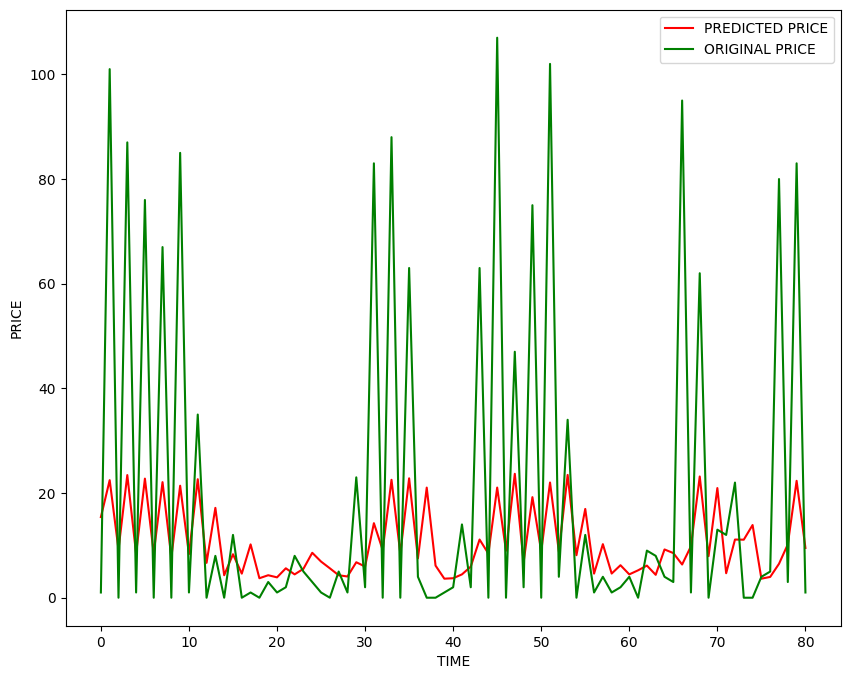

0.16444035959010306
29.578520735305357


81

In [223]:
plt.figure(figsize=(10,8))
plt.plot(y_predict,'r',label='PREDICTED PRICE')
plt.plot(y,'g',label='ORIGINAL PRICE')
plt.xlabel('TIME')
plt.ylabel('PRICE')
plt.legend()
plt.show()


from sklearn.metrics import r2_score as r2s
from sklearn.metrics import mean_squared_error as mse
r2 = r2s(y, predict)
mean_error = mse(y, predict)

print(r2)
print(np.sqrt(mean_error))
len(y_predict)

In [221]:
'''model.save('Stock days1.keras')'''